Noisy audio saved as noisy_voice_message.wav


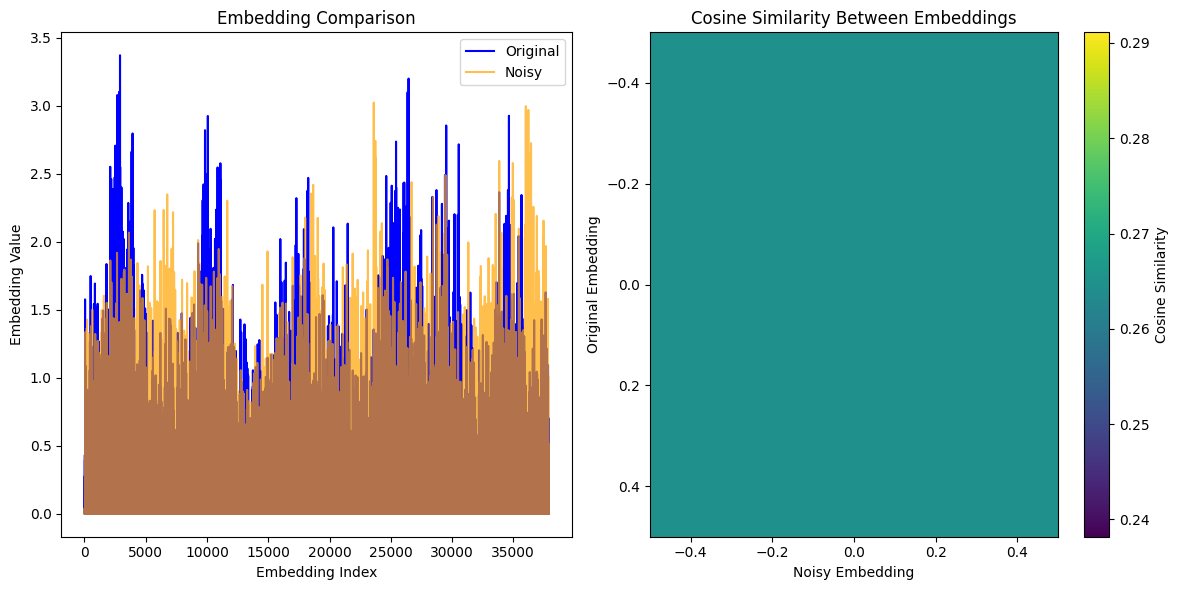

Average Cosine Similarity: 0.2646


In [ ]:
import numpy as np
import librosa
import librosa.display
import soundfile as sf
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Load pre-trained audio embedding model (YAMNet from TensorFlow Hub)
model = hub.load('https://tfhub.dev/google/yamnet/1')

# Load audio file
audio_path = '/content/original_audio.ogg'  # Replace with your audio file path
y, sr = librosa.load(audio_path, sr=None)

# Apply Noise Reduction Techniques as defined in previous code (phase shift, perceptual noise, silent modulation)
def add_inaudible_noise(audio, sr, noise_factor=0.5):
    stft_audio = librosa.stft(audio)
    magnitude, phase = np.abs(stft_audio), np.angle(stft_audio)

    # Generate noise and apply to high-frequency components
    noise = np.random.normal(0, noise_factor, magnitude.shape)
    magnitude_high_freq = magnitude * (magnitude > np.median(magnitude))
    magnitude_high_freq += noise

    noisy_audio_stft = magnitude_high_freq * np.exp(1j * phase)
    noisy_audio = librosa.istft(noisy_audio_stft)
    return noisy_audio

def add_phase_shifts(audio, shift_amount=0.05):
    stft_audio = librosa.stft(audio)
    magnitude, phase = np.abs(stft_audio), np.angle(stft_audio)
    phase_shift = np.random.uniform(-shift_amount, shift_amount, phase.shape)
    noisy_audio_stft = magnitude * np.exp(1j * (phase + phase_shift))
    return librosa.istft(noisy_audio_stft)

def add_perceptual_noise(audio, sr, noise_factor=0.1):
    stft_audio = librosa.stft(audio)
    magnitude, phase = np.abs(stft_audio), np.angle(stft_audio)
    perceptual_mask = magnitude > (0.5 * np.median(magnitude))
    noise = np.random.normal(0, noise_factor, magnitude.shape)
    magnitude[perceptual_mask] += noise[perceptual_mask]
    noisy_audio_stft = magnitude * np.exp(1j * phase)
    return librosa.istft(noisy_audio_stft)

# Apply noise transformations sequentially
noisy_audio = add_inaudible_noise(y, sr)
noisy_audio = add_phase_shifts(noisy_audio)
noisy_audio = add_perceptual_noise(noisy_audio, sr)

# Save noisy audio
output_path = 'noisy_voice_message.wav'
sf.write(output_path, noisy_audio, sr, subtype='PCM_16')
print(f"Noisy audio saved as {output_path}")

# Resample audio for YAMNet and extract embeddings
y_resampled = librosa.resample(y, orig_sr=sr, target_sr=16000)
noisy_resampled = librosa.resample(noisy_audio, orig_sr=sr, target_sr=16000)
original_embeddings = model(tf.convert_to_tensor(y_resampled, dtype=tf.float32))[1]
noisy_embeddings = model(tf.convert_to_tensor(noisy_resampled, dtype=tf.float32))[1]

# Calculate cosine similarity
original_flat = original_embeddings.numpy().flatten().reshape(1, -1)
noisy_flat = noisy_embeddings.numpy().flatten().reshape(1, -1)
similarity = cosine_similarity(original_flat, noisy_flat)

# Visualization
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(original_flat.flatten(), label='Original', color='blue')
plt.plot(noisy_flat.flatten(), label='Noisy', color='orange', alpha=0.7)
plt.title("Embedding Comparison")
plt.xlabel("Embedding Index")
plt.ylabel("Embedding Value")
plt.legend()

plt.subplot(1, 2, 2)
plt.imshow(similarity, cmap='viridis', aspect='auto')
plt.colorbar(label='Cosine Similarity')
plt.title("Cosine Similarity Between Embeddings")
plt.xlabel("Noisy Embedding")
plt.ylabel("Original Embedding")

plt.tight_layout()
plt.show()

average_similarity = np.mean(similarity)
print(f"Average Cosine Similarity: {average_similarity:.4f}")


In [ ]:
import noisereduce as nr
def reduce_noise_spectral_gate(audio, sr, noise_clip_duration=0.5):
     # Install with `pip install noisereduce`
    # Assume the first `noise_clip_duration` seconds are noise
    noise_clip = audio[:int(noise_clip_duration * sr)]
    # Apply noise reduction
    denoised_audio = nr.reduce_noise(y=audio, sr=sr, y_noise=noise_clip)
    return denoised_audio



In [ ]:
#Call the noise reduction functions
denoised_audio_spectral = reduce_noise_spectral_gate(noisy_audio, sr)

# Save and compare results
sf.write("denoised_spectral.wav", denoised_audio_spectral, sr, subtype='PCM_16')

print("Denoised audios saved for comparison!")

Denoised audios saved for comparison!


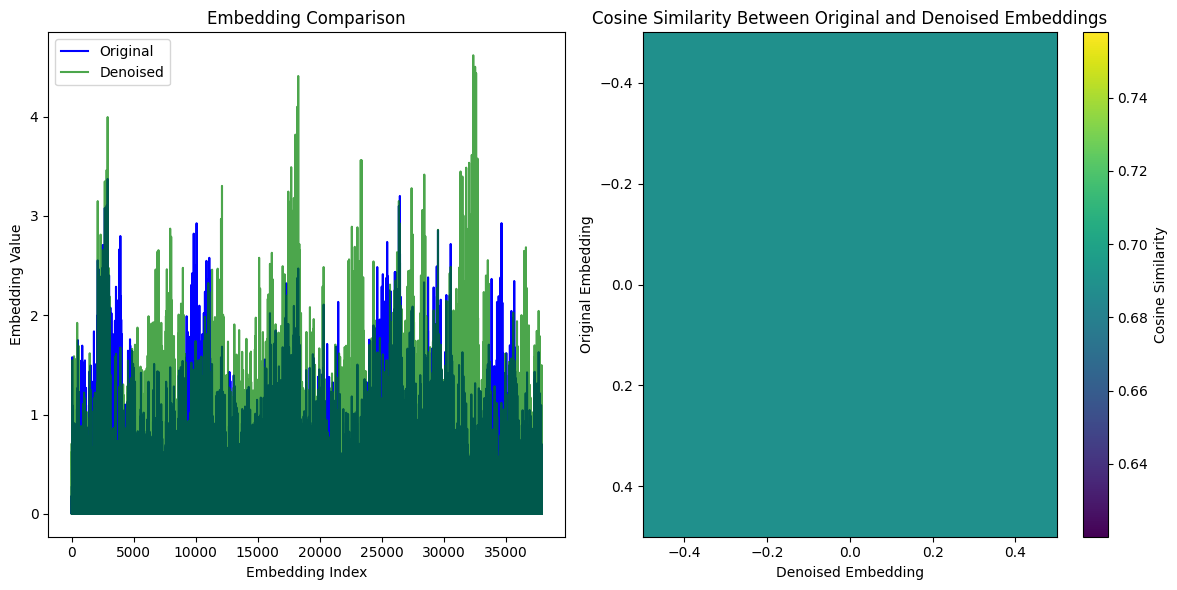

Average Cosine Similarity: 0.6890


In [ ]:
# Load the noise-reduced audio
denoised_audio_path = "denoised_spectral.wav"  # Path to the saved denoised audio
denoised_audio, sr_denoised = librosa.load(denoised_audio_path, sr=None)

# Resample the denoised audio to 16 kHz for YAMNet
denoised_resampled = librosa.resample(denoised_audio, orig_sr=sr_denoised, target_sr=16000)

# Extract embeddings using YAMNet
denoised_embeddings = model(tf.convert_to_tensor(denoised_resampled, dtype=tf.float32))[1]

# Calculate cosine similarity
denoised_flat = denoised_embeddings.numpy().flatten().reshape(1, -1)
original_flat = original_embeddings.numpy().flatten().reshape(1, -1)

similarity = cosine_similarity(original_flat, denoised_flat)

# Visualization
plt.figure(figsize=(12, 6))

# Embedding comparison plot
plt.subplot(1, 2, 1)
plt.plot(original_flat.flatten(), label='Original', color='blue')
plt.plot(denoised_flat.flatten(), label='Denoised', color='green', alpha=0.7)
plt.title("Embedding Comparison")
plt.xlabel("Embedding Index")
plt.ylabel("Embedding Value")
plt.legend()

# Cosine similarity heatmap
plt.subplot(1, 2, 2)
plt.imshow(similarity, cmap='viridis', aspect='auto')
plt.colorbar(label='Cosine Similarity')
plt.title("Cosine Similarity Between Original and Denoised Embeddings")
plt.xlabel("Denoised Embedding")
plt.ylabel("Original Embedding")

plt.tight_layout()
plt.show()

# Average similarity score
average_similarity = np.mean(similarity)
print(f"Average Cosine Similarity: {average_similarity:.4f}")
